## Slug Test for Unconfined Aquifer
**This test is taken from examples of AQTESOLV.**

In [1]:
%matplotlib inline
from ttim import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Set background parameters:

In [2]:
rw = 0.127 # well radius
rc = 0.0508 # well casing radius
L = 4.20624 # screen length
b = -9.9274 # aquifer thickness
zt = -0.1433 # depth to top of the screen
H0 = 0.4511 # initial displacement in the well
zb = zt - L # bottom of the screen

Slug:

In [3]:
Q = np.pi * rc ** 2 * H0
print('Slug:', round(Q, 5), 'm^3')

Slug: 0.00366 m^3


Load data:

In [4]:
data = np.loadtxt('data/falling_head.txt', skiprows = 2)
t = data[:, 0] / 60 / 60 / 24 #convert time from seconds to days
h = (10 - data[:, 1]) * 0.3048 #convert drawdown from ft to meters

In [5]:
print(t.min(), t.max())

2.3148148148148147e-05 0.0037731481481481483


Create single layer conceptual model:

In [6]:
ml_0 = ModelMaq(kaq=10, z=[0, b], Saq=1e-4, tmin=1e-5, tmax=0.01)
w_0 = Well(ml_0, xw=0, yw=0, rw=rw, rc=rc, tsandQ=[(0, -Q)], layers=0, wbstype='slug')
ml_0.solve()

self.neq  1
solution complete


In [7]:
#unknown parameters: kaq, Saq
ca_0 = Calibrate(ml_0)
ca_0.set_parameter(name='kaq0', initial=10, pmin=0)
ca_0.set_parameter(name='Saq0', initial=1e-4)
ca_0.series(name='obs', x=0, y=0, t=t, h=h, layer=0)
ca_0.fit(report=True)

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 602
    # data points      = 27
    # variables        = 2
    chi-square         = 0.00118484
    reduced chi-square = 4.7394e-05
    Akaike info crit   = -266.917594
    Bayesian info crit = -264.325920
[[Variables]]
    kaq0:  0.26163369 +/- 0.01726105 (6.60%) (init = 10)
    Saq0:  8.0116e-05 +/- 

In [8]:
display(ca_0.parameters)
print('RMSE:', ca_0.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,0.261634,0.017261,6.59741,0,inf,10,[0.26163369124253677]
Saq0,8.01158e-05,0.000029,35.8312,-inf,inf,0.0001,[8.011583184166792e-05]


RMSE: 0.006624419841400156


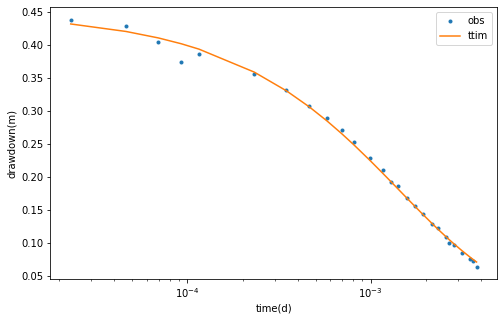

In [9]:
hm_0 = ml_0.head(0, 0, t, layers=0)
plt.figure(figsize = (8, 5))
plt.semilogx(t, h, '.', label='obs')
plt.semilogx(t, hm_0[0], label='ttim')
plt.xlabel('time(d)')
plt.ylabel('drawdown(m)')
plt.legend();

Try multilayer conceptual model:

In [10]:
#Determine elevation of each layer. 
#Thickness of each layer is set to be 0.5 m.
z0 = np.arange(zt, zb, -0.5)
z1 = np.arange(zb, b, -0.5)
zlay = np.append(z0, z1)
zlay = np.append(zlay, b)
zlay = np.insert(zlay, 0, 0)
nlay = len(zlay) - 1 #number of layers
Saq_1 = 1e-4 * np.ones(nlay)
Saq_1[0] = 0.1

In [11]:
ml_1 = Model3D(kaq=10, z=zlay, Saq=Saq_1, kzoverkh=1, \
             tmin=1e-5, tmax=0.01, phreatictop=True)
w_1 = Well(ml_1, xw=0, yw=0, rw=rw, tsandQ=[(0, -Q)], layers=1, rc=rc, wbstype='slug')
ml_1.solve()

self.neq  1
solution complete


In [12]:
ca_1 = Calibrate(ml_1)
ca_1.set_parameter(name='kaq0_21', initial=10, pmin=0)
ca_1.set_parameter(name='Saq0_21', initial=1e-4, pmin=0)
ca_1.series(name='obs', x=0, y=0, layer=1, t=t, h=h)
ca_1.fit(report = True)

......................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 27
    # variables        = 2
    chi-square         = 9.3197e-04
    reduced chi-square = 3.7279e-05
    Akaike info crit   = -273.399289
    Bayesian info crit = -270.807615
[[Variables]]
    kaq0_21:  2.08635448 +/- 0.05248548 (2.52%) (init = 10)
    Saq0_21:  0.01482294 +/- 0.00225647 (15.22%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_21, Saq0_21) = -0.888


In [13]:
display(ca_1.parameters)
print('RMSE:', ca_1.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_21,2.08635,0.052485,2.51565,0,inf,10,"[2.086354478423537, 2.086354478423537, 2.08635..."
Saq0_21,0.0148229,0.002256,15.2228,0,inf,0.0001,"[0.014822937705603945, 0.014822937705603945, 0..."


RMSE: 0.005875148929828214


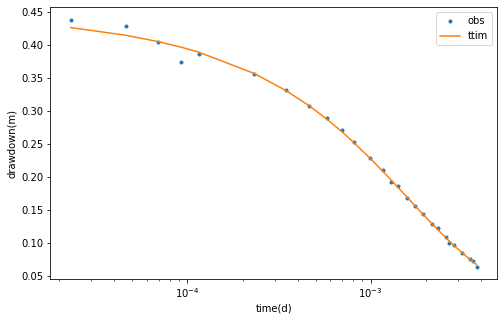

In [14]:
hm_1 = ml_1.head(0, 0, t, layers=1)
plt.figure(figsize = (8, 5))
plt.semilogx(t, h, '.', label='obs')
plt.semilogx(t, hm_1[0], label='ttim')
plt.xlabel('time(d)')
plt.ylabel('drawdown(m)')
plt.legend();

Try adding well screen resistance:

In [15]:
ml_2 = Model3D(kaq=10, z=zlay, Saq=Saq_1, kzoverkh=1, \
             tmin=1e-5, tmax=0.01, phreatictop=True)
w_2 = Well(ml_2, xw=0, yw=0, rw=rw, tsandQ=[(0, -Q)], layers=1, \
           rc=rc, res=0.1, wbstype='slug')
ml_2.solve()

self.neq  1
solution complete


In [16]:
ca_2 = Calibrate(ml_2)
ca_2.set_parameter(name='kaq0_21', initial=10, pmin=0)
ca_2.set_parameter(name='Saq0_21', initial=1e-4, pmin=0)
ca_2.set_parameter_by_reference(name='res', parameter=w_2.res, initial=0)
ca_2.series(name='obs', x=0, y=0, layer=1, t=t, h=h)
ca_2.fit(report = True)

.........................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 27
    # variables        = 3
    chi-square         = 8.2005e-04
    reduced chi-square = 3.4169e-05
    Akaike info crit   = -274.853444
    Bayesian info crit = -270.965933
[[Variables]]
    kaq0_21:  2.01415986 +/- 0.05689915 (2.82%) (init = 10)
    Saq0_21:  0.01917323 +/- 0.00326924 (17.05%) (init = 0.0001)
    res:     -8.4044e-04 +/- 4.3487e-04 (51.74%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_21, Saq0_21) = -0.915
    C(Saq0_21, res)     = -0.685
    C(kaq0_21, res)     =  0.589


In [17]:
display(ca_2.parameters)
print('RMSE:', ca_2.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_21,2.01416,0.056899,2.82496,0,inf,10,"[2.0141598605177466, 2.0141598605177466, 2.014..."
Saq0_21,0.0191732,0.003269,17.051,0,inf,0.0001,"[0.01917322856789272, 0.01917322856789272, 0.0..."
res,-0.000840439,0.000435,51.7433,-inf,inf,0,[-0.0008404389845247199]


RMSE: 0.005511107377123856


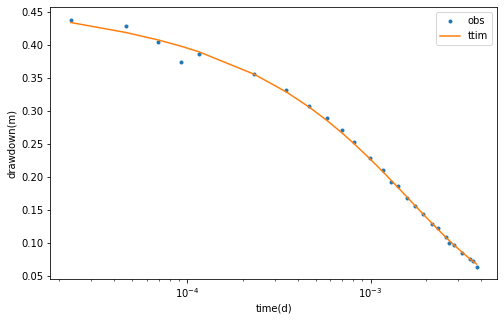

In [18]:
hm_2 = ml_2.head(0, 0, t, layers=1)
plt.figure(figsize = (8, 5))
plt.semilogx(t, h, '.', label='obs')
plt.semilogx(t, hm_2[0], label='ttim')
plt.xlabel('time(d)')
plt.ylabel('drawdown(m)')
plt.legend();

According to the rmse shown in table above, adding res does not improve the performance.

## Summary of values presented in AQTESOLV:

In [19]:
t = pd.DataFrame(columns=['k [m/d]', 'Ss [1/m]'], \
                index=['AQTESOLV', 'ttim-single', 'ttim-multi'])
t.loc['AQTESOLV'] = [2.616, 7.894E-5]
t.loc['ttim-single'] = ca_0.parameters['optimal'].values
t.loc['ttim-multi'] = ca_1.parameters['optimal'].values
t['RMSE'] = [0.001197, round(ca_0.rmse(), 6), round(ca_1.rmse(), 6)]
t

,k [m/d],Ss [1/m],RMSE
AQTESOLV,2.616,7.894e-05,0.001197
ttim-single,0.261634,8.01158e-05,0.006624
ttim-multi,2.08635,0.0148229,0.005875
